# Packages

In [6]:
import numpy as np
import pandas as pd #for loading csv Excel files
import itertools #to merge lists
from scipy.interpolate import interp1d,interp2d,CubicSpline,UnivariateSpline,RectBivariateSpline
import matplotlib.pyplot as pl #for plots

# Constants

In [54]:
c_ms=2.99792458*10.**8. #m/s
eV_to_J=1.602176634*10.**(-19.) #J=kg*(m**2/s)
eVc2_to_kg=eV_to_J/c_ms**2.
#print(eVc2_to_kg)
h_Js=6.62606957*10.**(-34.) #J*s=(kg*m**2)/s
hbar_Js=h_Js/(2.*np.pi) #J*s=(kg*m**2)/s
#hbar_Js=1.054571817*10.**(-34.) #J*s=(kg*m**2)/s
#print(hbar_Js)

1.05457172534e-34


# Data dark photon model

In [8]:
potentials=['attractive','repulsive'] 
datadarkphotonmodel=np.array([pd.read_csv('DataDarkPhotonModel/crosssec_'+str(potential)+'.csv',header=-1).values for potential in potentials]) #header=-1 needed to load da a from first line.
avals=np.array(datadarkphotonmodel[0][:,0]) #Same avals for both potentials.
#print(avals) 
uniqueavals=np.unique(avals)
#print(uniqueavals)
bvals=np.array(datadarkphotonmodel[0][:,1]) #Same bvals for both potentials.
#print(bvals) 
uniquebvals=np.unique(bvals)
#print(uniquebvals)
print(len(uniquebvals))
cvals=[datadarkphotonmodel[i][:,2] for i in range(0,len(datadarkphotonmodel))]
#print(cvals) 

1001


# Generate 2D interpolation function c(a,b)

In [161]:
#_____Extract lines in data dark photon model with same bvals (repeat each other)_____
ibvals=np.array([list(itertools.chain.from_iterable(np.argwhere(bvals==uniquebvals[i]))) for i in range(0,len(uniquebvals))])
#print(ibvals[0])
#_____For fixed b interpolate in terms of a: c(a)_____
#caint=np.array([[interp1d([avals[k] for k in ibvals[j]],[cvals[i][k] for k in ibvals[j]],kind='cubic',fill_value='extrapolate') for j in range(0,len(ibvals))] for i in range(0,len(potentials))])
caint=np.array([[interp1d([avals[k] for k in ibvals[j]],[cvals[i][k] for k in ibvals[j]],kind='cubic',fill_value='extrapolate') for j in range(0,len(ibvals))] for i in range(0,len(potentials))])
#print(caint)

In [162]:
#_____2D interpolation function c(a,b)_____
def cab(potential,a,b):
    if potential=='attractive':
        caInt=caint[0]
    elif potential=='repulsive':
        caInt=caint[1]
    #_____Evaluate all interpolation functions c(b) at b and interpolate in terms of a: c(a,b)_____
    cavals=[caInt[i](a) for i in range(0,len(caInt))]
    cab=interp1d(uniquebvals,cavals,kind='cubic',fill_value='extrapolate')(b) #,kind='cubic',fill_value='extrapolate'
    return cab
    
for potential in ['attractive']: #['attractive','repulsive']:
    for b in [0.1]: #[0.1,10.,100.,1000.,10000.]
        for a in [avals[0],avals[1],10**(-10.)]:
            print([a,b,cab(potential,a,b)])

[1e-05, 0.1, array(1.10814e-14)]
[1.05925e-05, 0.1, array(1.24335e-14)]
[1e-10, 0.1, array(-5.79385703e-16)]


# sigmaT(v)

In [114]:
c_ms

299792458.0

In [152]:
def sigmaT(potential,alphaX,mX,mphi,v):
    a=(1/(2.*alphaX))*(v/(c_ms*10.**(-3.))) #Divide by c to make a dimensionless. Ok.
    b=alphaX*(mX/mphi)
    b=4.52
    print('[a,b]='+str([a,b]))
    sigmaT=(16.*np.pi*cab(potential,a,b))/(mX**2.*(v**2/(c_ms*10.**(-3.))**2.))
    sigmaT_cm2=sigmaT/(5.05*10.**(13.))**2.
    sigmaTm_cm2g=sigmaT_cm2/(mX*1.78*10**(-24.))
    sigmaTm2=sigmaTm_cm2g*mX**3.
    return sigmaTm2

for potential in ['attractive']: #['attractive','repulsive']:
    for alphaX in [10.**(-2.)]:
        for mX in [200]: #GeV
            for mphi in [10**(-3.)]: #GeV.
                for v in [10]: #km/s
                    print(sigmaT(potential,alphaX,mX,mphi,v)) #Ok. In accordance with Fig.2 in Sean's paper 1302.3898.

[a,b]=[0.0016678204759907602, 4.52]
4.878655477746706


[a,b]=[0.00016678204759907602, 4.52]
[a,b]=[0.00020127134763332316, 4.52]
[a,b]=[0.00024289278109545435, 4.52]
[a,b]=[0.0002931212206904137, 4.52]
[a,b]=[0.00035373653194440785, 4.52]
[a,b]=[0.00042688664347579014, 4.52]
[a,b]=[0.0005151636597338084, 4.52]
[a,b]=[0.0006216957132915833, 4.52]
[a,b]=[0.0007502578115173007, 4.52]
[a,b]=[0.0009054056055212468, 4.52]
[a,b]=[0.001092636821536636, 4.52]
[a,b]=[0.0013185860751219597, 4.52]
[a,b]=[0.001591259971506678, 4.52]
[a,b]=[0.001920320822958206, 4.52]
[a,b]=[0.0023174290368124227, 4.52]
[a,b]=[0.0027966563068291188, 4.52]
[a,b]=[0.0033749842494789455, 4.52]
[a,b]=[0.00407290615454484, 4.52]
[a,b]=[0.00491515317331934, 4.52]
[a,b]=[0.005931570677176823, 4.52]
[a,b]=[0.007158175840649027, 4.52]
[a,b]=[0.008638433924897486, 4.52]
[a,b]=[0.010424798487215396, 4.52]
[a,b]=[0.01258057009451955, 4.52]
[a,b]=[0.015182139405113416, 4.52]
[a,b]=[0.01832169410325123, 4.52]
[a,b]=[0.022110485607848552, 4.52]
[a,b]=[0.026682771312513433, 4.52]
[a,b]

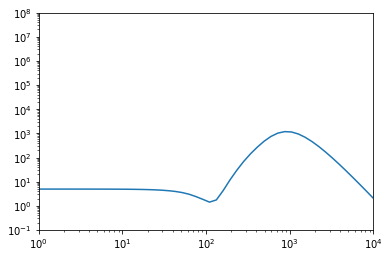

In [160]:
potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.

vvals=np.logspace(np.log10(1.),np.log10(10.**4.))
sigmavals=[sigmaT(potential,alphaX,mX,mphi,v) for v in vvals]

pl.xscale('log')
pl.yscale('log')
pl.xlim([1,10.**4.])
pl.ylim([0.1,10.**8.])
pl.plot(vvals,sigmavals)
pl.show()

[a,b]=[0.00016678204759907602, 4.52]
[a,b]=[0.00020127134763332316, 4.52]
[a,b]=[0.00024289278109545435, 4.52]
[a,b]=[0.0002931212206904137, 4.52]
[a,b]=[0.00035373653194440785, 4.52]
[a,b]=[0.00042688664347579014, 4.52]
[a,b]=[0.0005151636597338084, 4.52]
[a,b]=[0.0006216957132915833, 4.52]
[a,b]=[0.0007502578115173007, 4.52]
[a,b]=[0.0009054056055212468, 4.52]
[a,b]=[0.001092636821536636, 4.52]
[a,b]=[0.0013185860751219597, 4.52]
[a,b]=[0.001591259971506678, 4.52]
[a,b]=[0.001920320822958206, 4.52]
[a,b]=[0.0023174290368124227, 4.52]
[a,b]=[0.0027966563068291188, 4.52]
[a,b]=[0.0033749842494789455, 4.52]
[a,b]=[0.00407290615454484, 4.52]
[a,b]=[0.00491515317331934, 4.52]
[a,b]=[0.005931570677176823, 4.52]
[a,b]=[0.007158175840649027, 4.52]
[a,b]=[0.008638433924897486, 4.52]
[a,b]=[0.010424798487215396, 4.52]
[a,b]=[0.01258057009451955, 4.52]
[a,b]=[0.015182139405113416, 4.52]
[a,b]=[0.01832169410325123, 4.52]
[a,b]=[0.022110485607848552, 4.52]
[a,b]=[0.026682771312513433, 4.52]
[a,b]

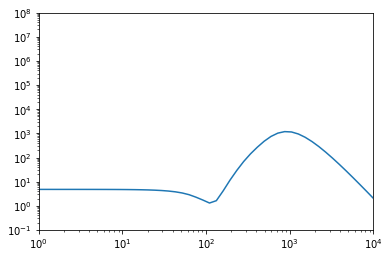

In [163]:
potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.

vvals=np.logspace(np.log10(1.),np.log10(10.**4.))
sigmavals=[sigmaT(potential,alphaX,mX,mphi,v) for v in vvals]

pl.xscale('log')
pl.yscale('log')
pl.xlim([1,10.**4.])
pl.ylim([0.1,10.**8.])
pl.plot(vvals,sigmavals)
pl.show()

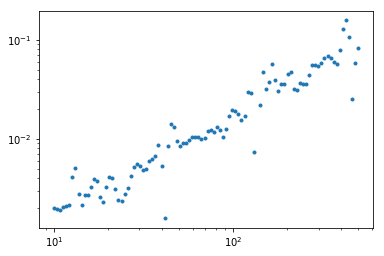

In [85]:
pl.xscale('log')
pl.yscale('log')
pl.plot(vvals,sigmamvals*vvals,'.')
pl.show()

In [ ]:
#### def sigmaT(potential,alphaX,mX,mphi,v):
    #_____Conversion to SI units_____
    #[mX]=GeV/c^2=10.**9.*eV/c^2=10.**9.*eVc2_to_kg*kg_____
    mX_kg=10.**9.*eVc2_to_kg*mX
    #print(mX_kg)
    #[mphi]=MeV/c^2=10.**6.*eV/c^2=10.**6.*eVc2_to_kg*kg_____
    mphi_kg=10.**6.*eVc2_to_kg*mphi
    #print(mphi_kg)
    #[v]=km/s=10**3 m/s_____
    v_ms=10.**3.*v
    #print(v_ms)
    #_____Dimensionless quantities a,b_____
    a=(1/(2.*alphaX))*(v_ms/c_ms) #Divide by c to make a dimensionless. Ok.
    b=alphaX*(mX/mphi)
    print('[a,b]='+str([a,b]))
    #_____sigmaT_____
    #sigmaT_m2=(16.*np.pi*cab(potential,a,b))*(hbar_Js**2./(mX_kg**2.*v_ms**2.))
    sigmaT_m2=(16.*np.pi*cab(potential,a,b))*(h_Js**2./(mX_kg**2.*v_ms**2.))
    sigmaT_cm2=(10.**2.)**2.*sigmaT_m2
    sigmaTmX_cm2g=sigmaT_cm2/(mX_kg*10.**3.)
    #print('sigmaT/m [cm**2]='+str(sigmaT_cm2))
    print('sigmaT/m [cm**2/g]='+str(sigmaTmX_cm2g))
    return sigmaT_cm2

for potential in ['attractive']: #['attractive','repulsive']:
    for alphaX in [10.**(-2.)]:
        for mX in [200]: #GeV
            for mphi in [1.]: #MeV.
                for v in [1000]: #km/s
                    print(sigmaT(potential,alphaX,mX,mphi,v)) #Ok. In accordance with Fig.2 in Sean's paper 1302.3898.

In [86]:
def sigmaTm(potential,alphaX,mX,mphi,v):
    #_____Conversion to SI units_____
    #[mX]=GeV/c^2=10.**9.*eV/c^2=10.**9.*eVc2_to_kg*kg_____
    mX_kg=10.**9.*eVc2_to_kg*mX
    #_____sigmaT_____
    sigmaT_cm2=sigmaT(potential,alphaX,mX,mphi,v)
    #_____sigmaT/m_____
    sigmaTmX_cm2g=sigmaT_cm2/(mX_kg*10.**3.)
    return sigmaTmX_cm2g

for potential in ['attractive']: #['attractive','repulsive']:
    for alphaX in [10.**(-2.)]:
        for mX in [200]: #GeV
            for mphi in [1.]: #MeV.
                for v in [1000]: #km/s
                    print(sigmaTm(potential,alphaX,mX,mphi,v)) #Ok. In accordance with Fig.2 in Sean's paper 1302.3898.

[a,b]=[0.16678204759907603, 2.0]
sigmaT/m [cm**2/g]=0.004853003147841062
0.004853003147841062
